# FloPy3

### FloPy3 working stack demo

A short demonstration of some of the `flopy3` awesomeness

In [1]:
%matplotlib inline
from __future__ import print_function
import os
import numpy as np
import pandas as pd

import flopy

### Model Inputs

Load and run an existing model.

In [2]:
# first lets load an existing model
model_ws = "data"
ml = flopy.modflow.Modflow.load("freyberg", model_ws=os.path.join('..', 'data', 'freyberg'), verbose=True, version='mf2005')
ml.exe_name = "mf2005"
ml.dis.sr.rotation = 15
ml.run_model()


Creating new model with name: freyberg
--------------------------------------------------

Parsing the namefile --> ../data/freyberg/freyberg.nam
Setting filehandles:

--------------------------------------------------
External unit dictionary:
{1: filename:../data/freyberg/freyberg.bas, filetype:BAS6, 7: filename:../data/freyberg/freyberg.lst, filetype:LIST, 11: filename:../data/freyberg/freyberg.lpf, filetype:LPF, 12: filename:../data/freyberg/freyberg.wel, filetype:WEL, 50: filename:../data/freyberg/freyberg.cbb, filetype:DATA(BINARY), 14: filename:../data/freyberg/freyberg.riv, filetype:RIV, 18: filename:../data/freyberg/freyberg.rch, filetype:RCH, 19: filename:../data/freyberg/freyberg.pcg, filetype:PCG, 22: filename:../data/freyberg/freyberg.oc, filetype:OC, 29: filename:../data/freyberg/freyberg.dis, filetype:DIS, 30: filename:../data/freyberg/freyberg.hds, filetype:DATA(BINARY), 31: filename:../data/freyberg/freyberg.ddn, filetype:DATA(BINARY)}
--------------------------------

(True, [])

### Changing the numeric array formats 

Determine the current output format of the starting heads and change to a different format. 

In [3]:
print(ml.bas6.strt[0].format.fortran)
ml.bas6.strt[0].format.fortran = '(20F10.3)'
print(ml.bas6.strt[0].format.fortran)

(20E15.6)
(20F10.3)


### Make a copy of the model in another directory

Change the working directory of the model, write (copy) the input files in the directory, and rerun the model.

In [4]:
ml.change_model_ws(model_ws)
ml.write_input()
ml.run_model()


changing model workspace...
   data

Writing packages:
   Package:  DIS
   Package:  BAS6
   Package:  LPF
   Package:  WEL
   Package:  RIV
   Package:  RCH
   Package:  PCG
   Package:  OC
 
FloPy is using the following executable to run the model: /Users/jdhughes/Documents/Development/bin/mac/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 x/x/2015                        

 Using NAME file: freyberg.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2015/12/09 18:08:29

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2015/12/09 18:08:29
 Elapsed run time:  0.007 Seconds

  Normal termination of simulation


(True, [])

Let's looks at some plots

plotting LPF package Util3d instance: hani
plotting LPF package Util3d instance: wetdry
plotting LPF package Util3d instance: vka
plotting LPF package Util3d instance: vkcb
plotting LPF package Util3d instance: hk
plotting LPF package Util3d instance: sy
plotting LPF package Util3d instance: ss


/Users/jdhughes/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


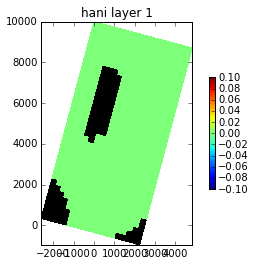

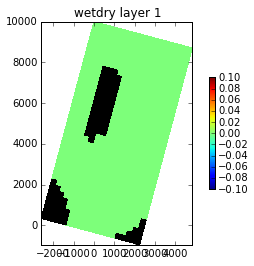

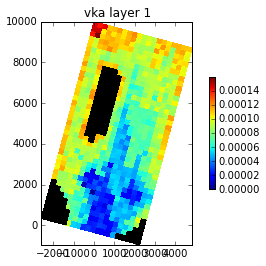

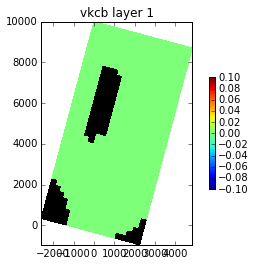

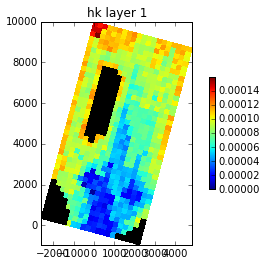

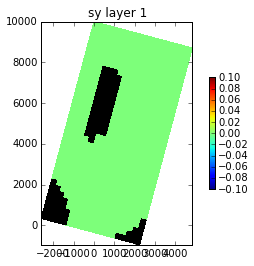

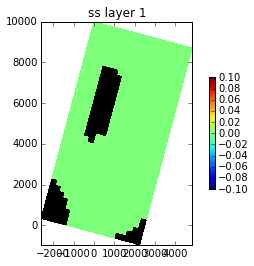

In [5]:
ml.lpf.plot()

plotting DIS package Util2d instance: top
plotting DIS package Util3d instance: _ModflowDis__thickness
plotting DIS package Util3d instance: botm


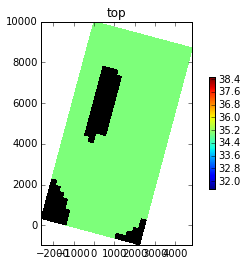

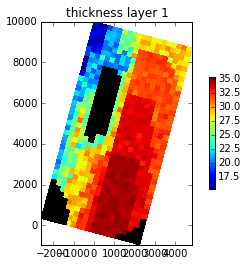

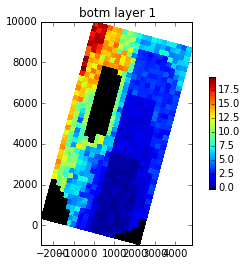

In [6]:
ml.dis.plot()

plotting RIV package MfList instance: stress_period_data


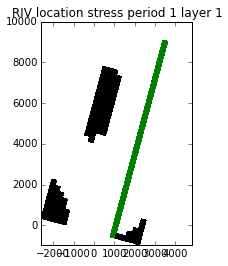

In [7]:
ml.riv.plot()

Let's write a giant shapefile with all model inputs

In [8]:
ml.to_shapefile(os.path.join(model_ws,"freyberg.shp"))

Let's also write a netCDF file with all model inputs

In [9]:
ml.export(os.path.join(model_ws,"freyberg.nc"))

('2015-12-09 18:08:31.426493 WARNING: removing existing nc file: data/freyberg.nc\n',)
('2015-12-09 18:08:31.426990 starting: initializing attributes\n',)
('2015-12-09 18:08:31.427057 finished: initializing attributes, took: 0:00:00.000067\n',)
('2015-12-09 18:08:31.427087 starting: getting 3D array for botm\n',)
('2015-12-09 18:08:31.427159 finished: getting 3D array for botm, took: 0:00:00.000072\n',)
('2015-12-09 18:08:31.427242 starting: creating variable: botm\n',)
('2015-12-09 18:08:31.427281 starting: initializing geometry\n',)
('2015-12-09 18:08:31.429321 starting: building grid crs using proj4 string: +init=EPSG:4326\n',)
('2015-12-09 18:08:31.429536 finished: building grid crs using proj4 string: +init=EPSG:4326, took: 0:00:00.000215\n',)
('2015-12-09 18:08:31.429914 starting: projecting grid cell center arrays from <pyproj.Proj object at 0x10b8cf120> to <pyproj.Proj object at 0x10b8cf1f0>\n',)
('2015-12-09 18:08:31.429990 finished: projecting grid cell center arrays from <py

### Run the model

In [10]:
ml.run_model()

FloPy is using the following executable to run the model: /Users/jdhughes/Documents/Development/bin/mac/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 x/x/2015                        

 Using NAME file: freyberg.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2015/12/09 18:08:31

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2015/12/09 18:08:31
 Elapsed run time:  0.008 Seconds

  Normal termination of simulation


(True, [])

### Output inspection

First, let's look at the list file

In [11]:
mfl = flopy.utils.MfListBudget(os.path.join(model_ws,"freyberg.list"))
df_flux, df_vol = mfl.get_dataframes(start_datetime="10-21-2015")
df_flux # multiindex columns

,STORAGE_IN,CONSTANT_HEAD_IN,WELLS_IN,RIVER_LEAKAGE_IN,RECHARGE_IN,TOTAL_IN,STORAGE_OUT,CONSTANT_HEAD_OUT,WELLS_OUT,RIVER_LEAKAGE_OUT,RECHARGE_OUT,TOTAL_OUT,IN-OUT,PERCENT_DISCREPANCY
2015-10-21 00:00:10.000022,0,0,0,0.004194,0.0695,0.073694,0,0.004735,0.02205,0.04691,0,0.073695,-6.407500e-07,-0


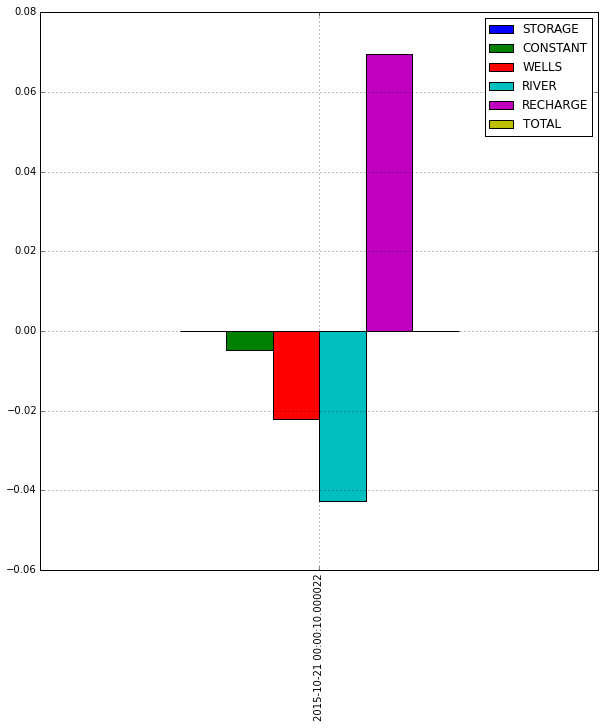

In [12]:
groups = df_flux.groupby(lambda x:x.split('_')[-1],axis=1).groups
df_flux_in = df_flux.loc[:,groups["IN"]]
df_flux_in.columns = df_flux_in.columns.map(lambda x:x.split('_')[0])

df_flux_out = df_flux.loc[:,groups["OUT"]]
df_flux_out.columns = df_flux_out.columns.map(lambda x:x.split('_')[0])


df_flux_delta = df_flux_in - df_flux_out
#df_flux_delta = df_flux.loc[:,"in"] - df_flux.loc[:,"out"]
df_flux_delta.plot(kind="bar",figsize=(10,10),grid=True)

Let's look at head

In [13]:
# if you pass the model instance, then the plots will be offset and rotated
h = flopy.utils.HeadFile(os.path.join(model_ws,"freyberg.hds"),model=ml)

/Users/jdhughes/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):


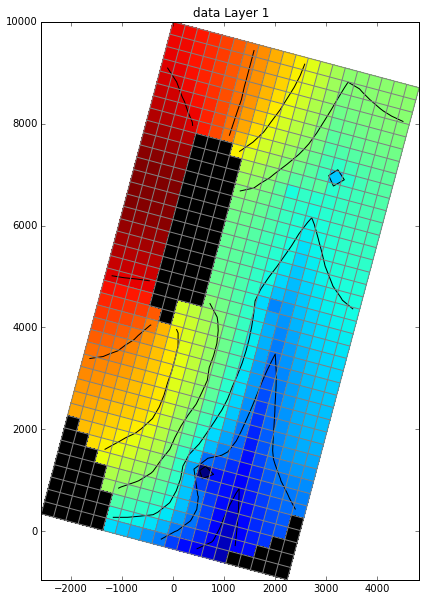

In [14]:
h.plot(contour=True,grid=True,figsize=(10,10))

In [15]:
#let's write these heads to shapefile
h.to_shapefile(os.path.join(model_ws,"freyburg_head.shp"))

### or more fine-grained plotting control with `ModelMap` - see the other notebooks